# Stroke Prediction Classification


### **Introduction:**

The 5th highest cause of death and the leading cause of disability in the United States is due in part to strokes (Cerebrovascular Accidents). Strokes are the result of an insufficient supply of oxygen and nutrients to the brain due to a blood vessel bursting. Subsequently, brain cells die, which can often cause right-sided weakness/paralysis, and sensory impairment.

This prediction classification project will answer the question of whether or not someone is likely to experience a stroke based on 8 different core factors relating to health and demographic.

The “Stroke Prediction Dataset”, acquired from kaggle.com, contains 12 columns, including different factors that may affect someone’s likelihood of experiencing a stroke, as well as whether or not the patient experienced a stroke, and other patient information.

In [43]:
library(repr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(ggplot2)
options(repr.matrix.max.rows = 6)

### **Preliminary exploratory data analysis:**

Although not all values are used, we must ensure that we properly tidy the data into a usable format. Tidy data entails:
* Each row has a single observation.
* Each column has a single variable.
* Each value was in a single cell.

The data included almost all these components, except for N/A values in the bmi column of the data set. Removing these observations, the dataset is now tidy.
Additionally, changing each variable to its correct type can be beneficial (even if it is not used), since it will help with usability later on if needed.

In [54]:
url <- "https://raw.githubusercontent.com/romansinkus/DS_Group_Project/main/healthcare-dataset-stroke-data.csv"
untidy_stroke_data <- read_csv(url)
stroke_data <- untidy_stroke_data %>%
    select(-id) %>% 
    mutate(stroke = as_factor(stroke)) %>%
    mutate(bmi = as.numeric(bmi)) %>% 
    mutate(heart_disease = as_factor(heart_disease)) %>%
    mutate(Residence_type = as_factor(Residence_type)) %>%
    mutate(smoking_status = as_factor(smoking_status)) %>%
    mutate(work_type = as_factor(work_type)) %>%
    mutate(gender = as_factor(gender)) %>%
    mutate(ever_married = as_factor(ever_married)) %>%
    mutate(hypertension = as_factor(hypertension)) %>% 
    rename(residence_type = Residence_type) %>% 
    filter(!is.na(bmi))

stroke_data

Parsed with column specification:
cols(
  id = col_double(),
  gender = col_character(),
  age = col_double(),
  hypertension = col_double(),
  heart_disease = col_double(),
  ever_married = col_character(),
  work_type = col_character(),
  Residence_type = col_character(),
  avg_glucose_level = col_double(),
  bmi = col_character(),
  smoking_status = col_character(),
  stroke = col_double()
)

Warning message:
“Problem with `mutate()` input `bmi`.
ℹ NAs introduced by coercion
ℹ Input `bmi` is `as.numeric(bmi)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke
<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>
Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
Female,44,0,0,Yes,Govt_job,Urban,85.28,26.2,Unknown,0


Now that the data has been tidied and optimized for usability, it can be split into the training data and testing day (75% will be allocated as training data).

In [30]:
stroke_split <- initial_split(stroke_data, prop = 0.75, strata = stroke)
stroke_train <- training(stroke_split)
stroke_test <- testing(stroke_split)

Below is a table summarizing the three different categorical variables that are possible predictors for the model. We calculateed the average and median for each variable.

Based on the summarization of the training data, most people indicated they were middle-aged, and had healthy average glucose levels (this range is typically from 90-110 mg/dL). The average patient observed exhibited a body mass index 

In [55]:
avg_values <- stroke_train %>% 
    summarize(age_avg = mean(age, na.rm = TRUE),
            avg_glucose_level_avg = mean(avg_glucose_level, na.rm = TRUE),
            bmi_avg = mean(bmi, na.rm = TRUE))
avg_values

age_avg,avg_glucose_level_avg,bmi_avg
<dbl>,<dbl>,<dbl>
43.29239,106.3435,28.84363


In [28]:
categorical_values <- stroke_train %>%
    group_by(stroke) %>% 
    summarize(n = n())

categorical_values

`summarise()` ungrouping output (override with `.groups` argument)



stroke,n
<fct>,<int>
0,3646
1,187


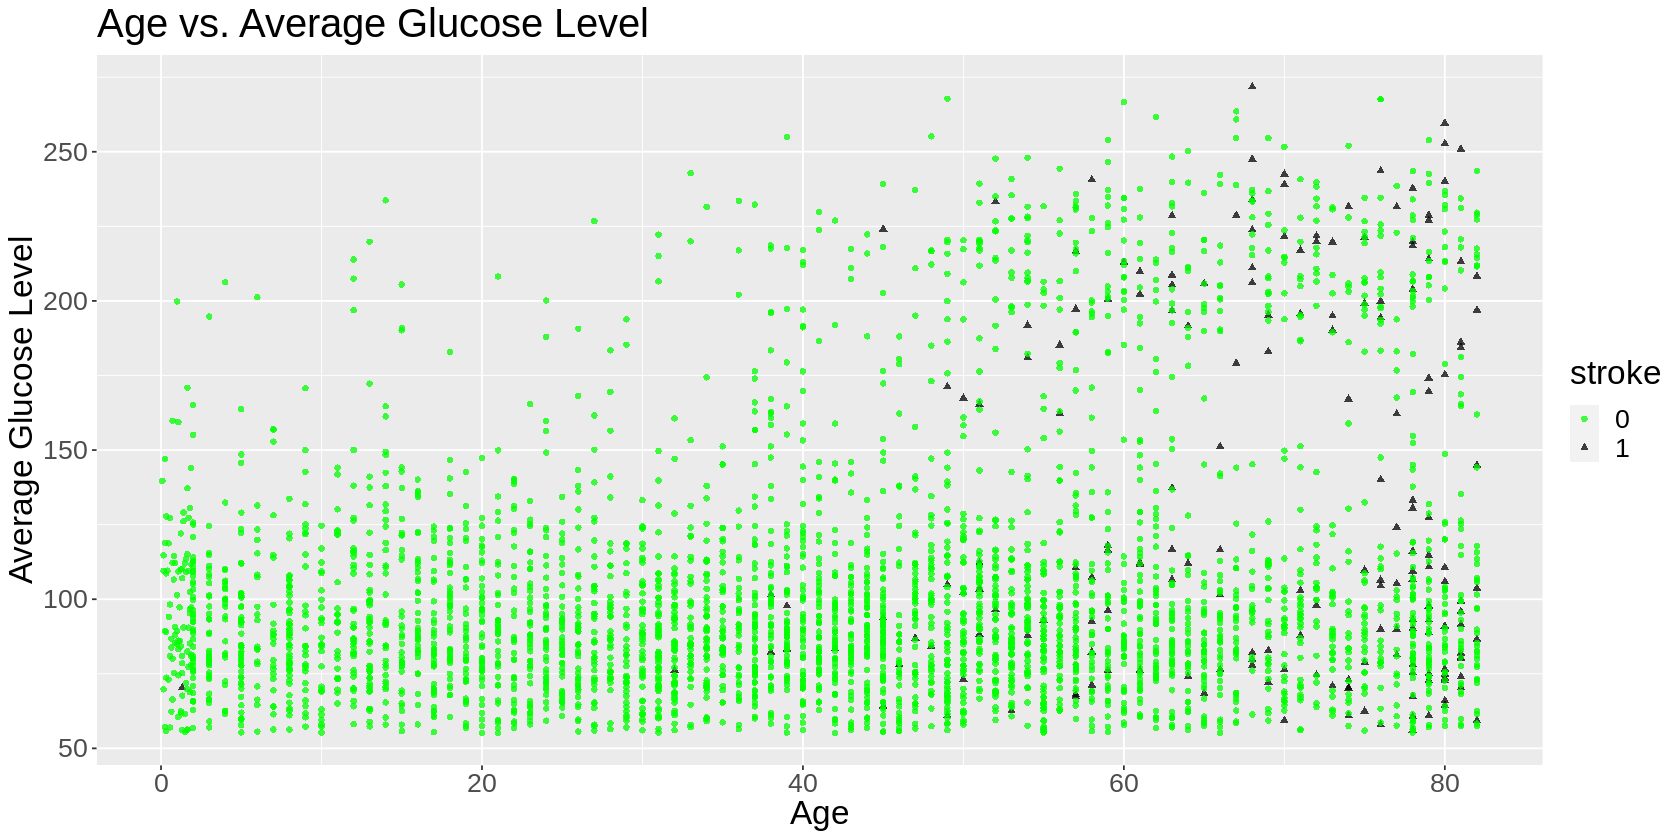

In [21]:
options(repr.plot.width = 14, repr.plot.height = 7)

age_vs_avg_glucose_level_plot <- stroke_train %>% 
    ggplot(aes(x = age, y = avg_glucose_level))+
    geom_point(aes(color = stroke, shape = stroke), alpha = 0.75)+
    labs(x = "Age", y = "Average Glucose Level", fill = "Stroke")+
    ggtitle("Age vs. Average Glucose Level")+
    theme(text = element_text(size = 20))+
    #scale_fill_brewer(palette = "Set2")
    scale_colour_manual(values = c("green", "black"))

age_vs_avg_glucose_level_plot

Warning message:
“Removed 163 rows containing missing values (geom_point).”


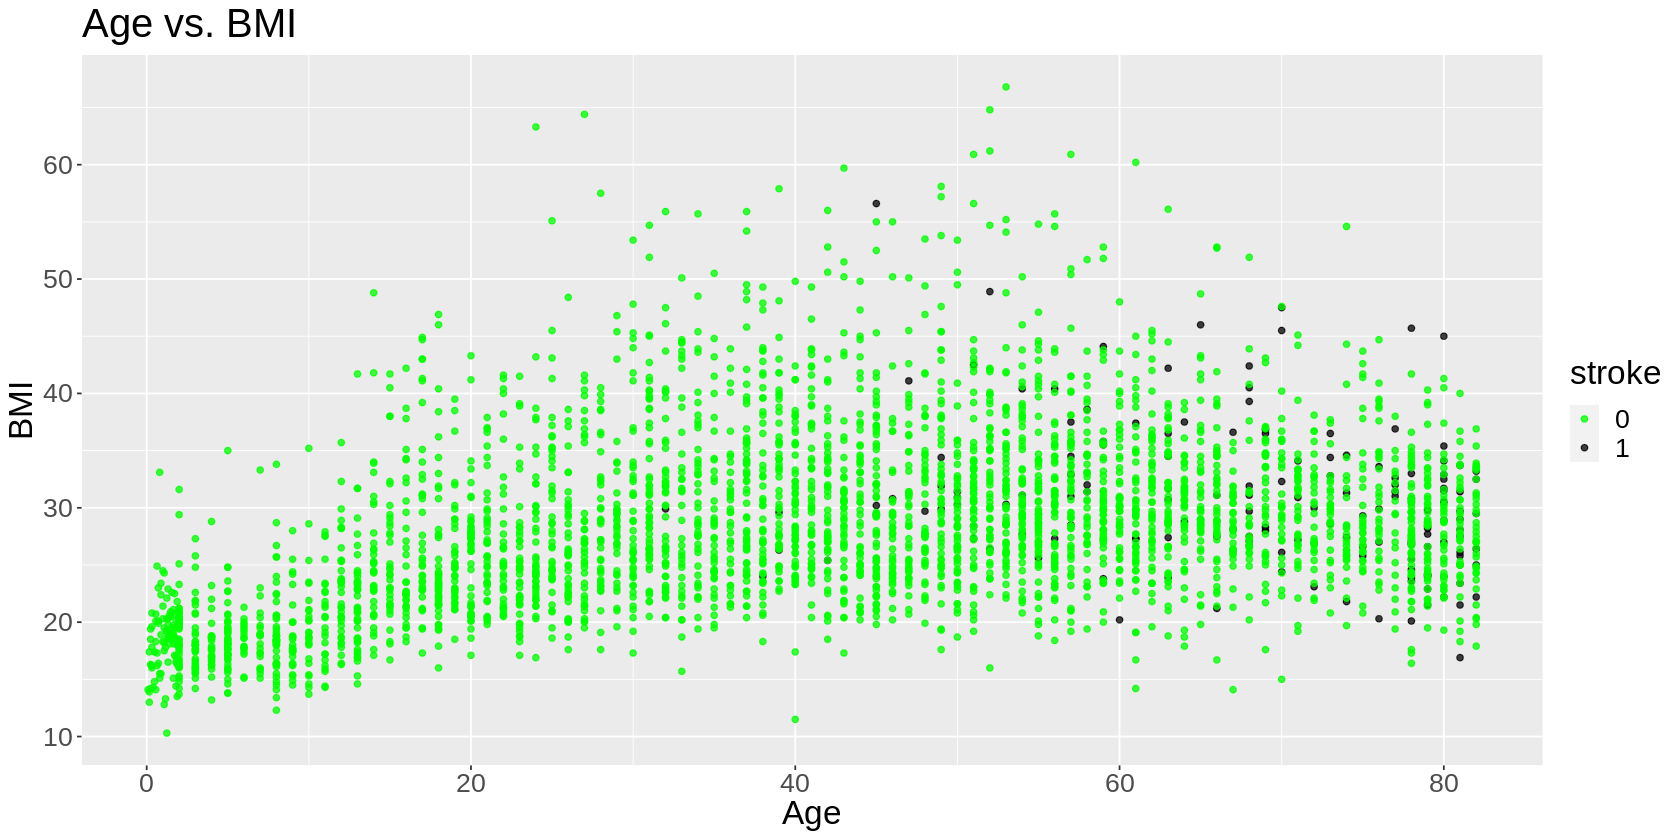

In [22]:
options(repr.plot.width = 14, repr.plot.height = 7)

age_vs_bmi_plot <- stroke_train %>% 
    ggplot(aes(x = age, y = bmi))+
    geom_point(aes(color = stroke), alpha = 0.75)+
    labs(x = "Age", y = "BMI", fill = "Stroke")+
    ggtitle("Age vs. BMI")+
    theme(text = element_text(size = 20))+
    scale_colour_manual(values = c("green", "black"))

age_vs_bmi_plot

Warning message:
“Removed 163 rows containing missing values (geom_point).”


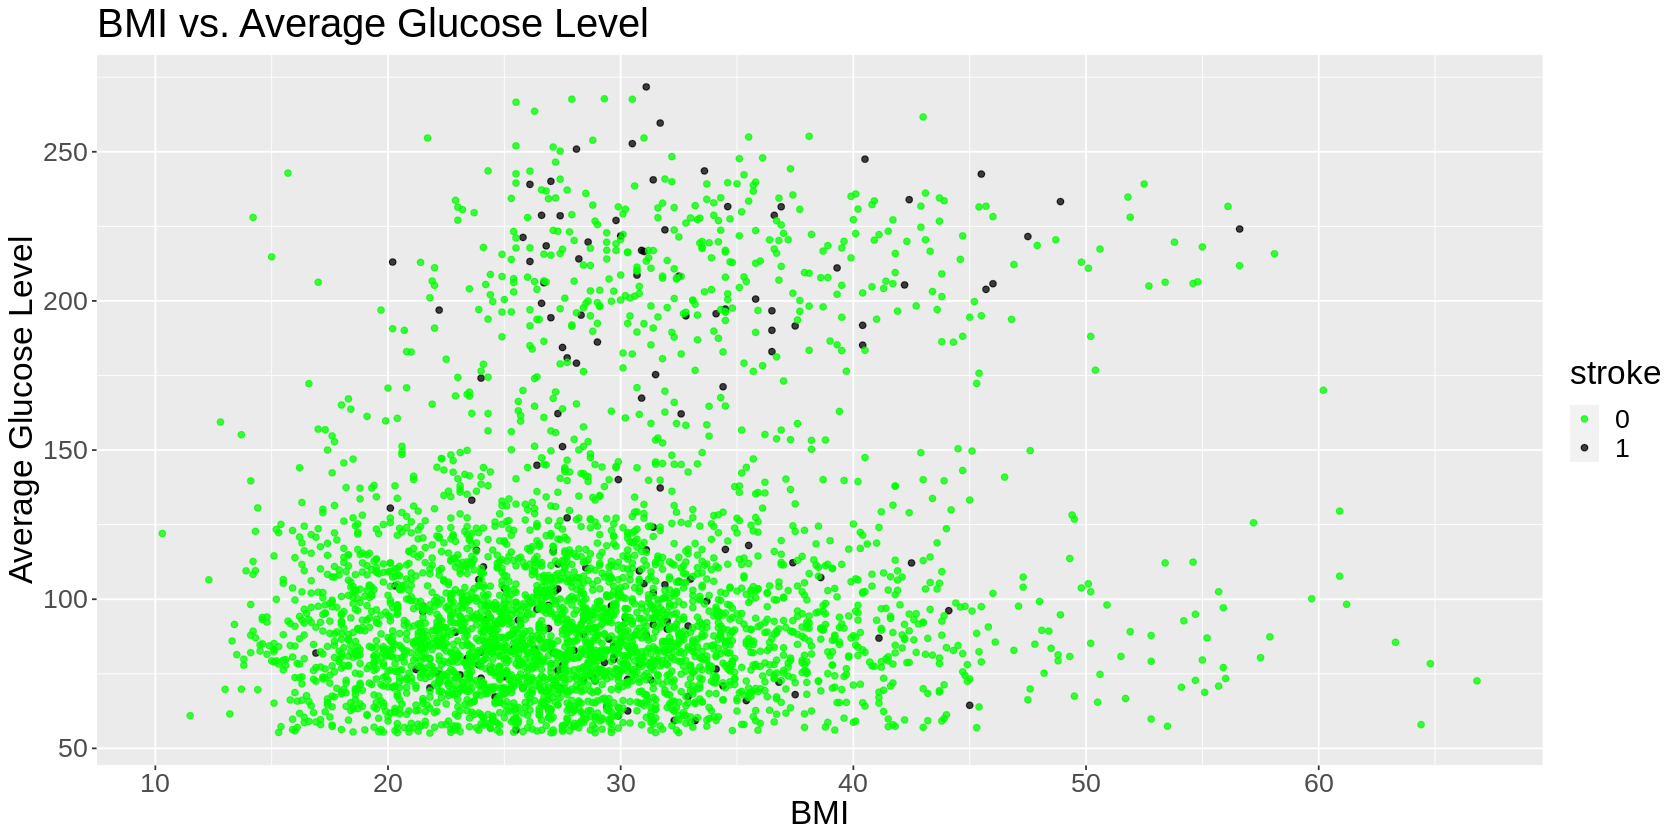

In [23]:
bmi_vs_avg_glucose_level_plot <- stroke_train %>% 
    ggplot(aes(x = bmi, y = avg_glucose_level))+
    geom_point(aes(color = stroke), alpha = 0.75)+
    labs(x = "BMI", y = "Average Glucose Level", fill = "Stroke")+
    ggtitle("BMI vs. Average Glucose Level")+
    theme(text = element_text(size = 20))+
    scale_colour_manual(values = c("green", "black"))

bmi_vs_avg_glucose_level_plot

### **Methods:**

We will be using the variables that could possibly have a direct or indirect effect on strokes, containing a combination of categorical variables, discrete variables, and continuous variables. We will be observing the gender, age, hypertension, heart disease, residence type, average glucose level, body mass index, and smoking status of individuals to predict whether they are more likely to have a stroke. 

The data was already tidy, since each row had a single observation, each column had a single variable and each value was in a single cell. However, we removed some redundant columns that were not needed in our analysis such as id, if the patient was ever married and the work type since they were not directly related or as important as other factors.

Describe at least one way that you will visualize the results:


### **Expected Outcomes and Significance:**

We expect to find a trend that can help determine if a patient is more likely to suffer from a stroke. This depends on several factors in question, based on a patient’s health or living habits or demographics. For example, smoking, having a heart disease or living in a polluted area would lead to higher chances of a stroke. 

What impact could such findings have?

Using this prediction, predicting a stroke would be an easier and more efficient process. It could help many patients seek help at an early stage, to prevent serious outcomes from occuring.

**Future Questions:**